# Fine tuning LLM for Summarization

In [ ]:
############
!pip install wikipedia
!pip install -U bitsandbytes transformers accelerate

In [2]:
import wikipedia
import torch
from tqdm import tqdm
import json
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import random
from sklearn.model_selection import train_test_split
import re

In [3]:
device='cpu'
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
assert str(device)=='cuda' or str(device)=='mps'
print(device)

cuda


## 1. Dataset Selection: Collect Wikipedia Articles

In [ ]:

wikipedia.set_lang("fr")

def clean_article_text(text):
    """
        Clean the article text:
        - remove section titles
        - characters \n and \t
    """
    lines = text.split('\n')

    # filter out lines that match section title pattern (== Section ==, etc)
    cleaned_lines = [line for line in lines if not re.match(r"^\s*={2,}.*?={2,}\s*$", line)]
    cleaned_text = " ".join(cleaned_lines)
    cleaned_text = cleaned_text.replace("\t", " ")

    # replace multiple spaces with single space and strip
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text

def get_articles(n):
    articles = []
    with tqdm(total=n, desc="Collecting French Wikipedia Articles") as pbar:
        while len(articles) < n:
            try:
                title = wikipedia.random()
                page = wikipedia.page(title)

                if len(page.content.split()) >= 500 and len(page.content.split()) <=4000:  # Filter for 500+ words and <=4000
                    articles.append({"title": title, "text": page.content})
                    pbar.update(1)  # update progress bar when an article is added
            except Exception as e:
                continue  #skip errors (page not found etc)
    return articles
n=5000
dataset = get_articles(n)

for data in dataset:
    data["text"] = clean_article_text(data["text"])

# save to JSON

with open(f"fr_wiki_articles_{n}.json", "w", encoding="utf-8") as f:
    json.dump(dataset, f)
print("Dataset saved to file!")

Dataset saved to file!


## 2. Dataset Annotation: generating synthetic summaries of the articles

### Loading LLM into GPU

In [ ]:
# put LLM in GPU

# use model with 4-bit quantization to save memory

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type="nf4",  # normalized float 4-bit
    bnb_4bit_compute_dtype=torch.bfloat16,  # compute in bfloat16
    bnb_4bit_use_double_quant=True # nested quantization
)



#model_name = "Qwen/Qwen2.5-32B-Instruct"# using Qwen2.5-32B-Instruct # COULD NOT FIT INTO T4
model_name="Qwen/Qwen2.5-14B-Instruct" # trying smaller model


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
)


model.to(device)
print(f"{model_name} is in {device}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/47.5k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/3.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/1.70G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen/Qwen2.5-14B-Instruct is in cuda


In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.do_sample = True

In [ ]:

# Only run this to load the 5000 datasets from json
n=5000
# Load the annotated dataset
with open(f"fr_wiki_articles_{n}.json", "r", encoding="utf-8") as f:
    dataset = json.load(f)
assert len(dataset)==n
print(dataset[0])


In [ ]:
print(n)

5000


In [ ]:
prompt_prefix = "Résume en quelques phrases en français l'article suivant. Il faut que le résumé soit court et représente les informations les plus importantes."
prompt_template = """<human>: {prompt_prefix}

ARTICLE: {article_text}

<assistant>:"""

In [ ]:
#  WORKS NOW
def generate_summary_batch(batch_texts, text_truncation_length=6000):
    prompts = [prompt_template.format(
        prompt_prefix=prompt_prefix,
        article_text=text[:text_truncation_length]
        )
               for text in batch_texts]
    encoding = tokenizer(prompts, padding=True, return_tensors="pt").to("cuda")
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )

    # the LLM echoes the prompt before the response,
    # so we have to remove beginning (looks like prompt_template which means it contains the whole article)
    # --> KEEP EVERYTHING AFTER <assistant>:
    summaries = []
    for i, output in enumerate(outputs):
        summary = tokenizer.decode(output, skip_special_tokens=True)
        #print("\n" + "!"*80)
        #print("Raw output:", summary)
        #print("!"*80)
        assistant_idx = summary.find("<assistant>:")
        assert assistant_idx != -1, "<assistant> not found in output"
        start = assistant_idx + len("<assistant>:")+1
        cleaned_summary = summary[start:]
        cleaned_summary = cleaned_summary.replace('<assistant>:', '').strip() # sometimes <assistant> is in output twice
        summaries.append(cleaned_summary)

    #print("\n" + "-"*80)
    #print("Processed summary:", summaries[0])
    #print("-" * 80)
    return summaries

### To start from 0 (no checkpoint)

In [ ]:
annotated_dataset = []
batch_size = 1 # T4 struggles to handle more

for i in tqdm(range(0, len(dataset), batch_size), desc="Annotating Articles"):
    batch = dataset[i:i + batch_size]
    batch_texts = [article["text"] for article in batch]
    try:
        summaries = generate_summary_batch(batch_texts)
        for article, summary in zip(batch, summaries):
            annotated_dataset.append({
                "title": article["title"],
                "text": article["text"],
                "summary": summary
            })
        # checkpoint every number of batches summaries
        if len(annotated_dataset) % (5*batch_size) == 0 and batch_size != 1:
            checkpoint_file = f"fr_wiki_annotated_checkpoint_{len(annotated_dataset)}.json"
            with open(checkpoint_file, "w", encoding="utf-8") as f:
                json.dump(annotated_dataset, f)
            print(f"\nCheckpoint saved: {checkpoint_file}")
    except Exception as e:
        print(f"Error on batch starting at index {i}: {e}")
        raise e

#save
with open(f"fr_wiki_annotated_{n}.json", "w", encoding="utf-8") as f:
    json.dump(annotated_dataset, f)

print(f"Done! Annotated dataset saved and downloaded as 'fr_wiki_annotated_{n}.json'.")

### For restarting from checkpoint

In [ ]:
START_INDEX=960
with open(f"fr_wiki_annotated_checkpoint_{START_INDEX}.json", "r", encoding="utf-8") as f:
    annotated_dataset = json.load(f)
assert len(annotated_dataset)==START_INDEX

print(annotated_dataset[0]["title"])
print(annotated_dataset[0]["text"])
print("_____________")
print(annotated_dataset[0]["summary"])
batch_size = 1
print(batch_size)

In [ ]:
print(len(annotated_dataset))
assert len(annotated_dataset)==START_INDEX

960


In [ ]:
print(f"starting from {START_INDEX}")
for i in tqdm(range(START_INDEX, len(dataset), batch_size), desc="Annotating Articles"):
    batch = dataset[i:i + batch_size]
    batch_texts = [article["text"] for article in batch]
    try:
        summaries = generate_summary_batch(batch_texts)
        for article, summary in zip(batch, summaries):
            annotated_dataset.append({
                "title": article["title"],
                "text": article["text"],
                "summary": summary
            })
        # checkpoint every number of batches summaries
        if len(annotated_dataset) % (5*batch_size) == 0 and batch_size != 1:
            checkpoint_file = f"fr_wiki_annotated_checkpoint_{len(annotated_dataset)}.json"
            with open(checkpoint_file, "w", encoding="utf-8") as f:
                json.dump(annotated_dataset, f)
            print(f"\nCheckpoint saved: {checkpoint_file}")
    except Exception as e:
        print(f"Error on batch starting at index {i}: {e}")
        raise e

#save
with open(f"fr_wiki_annotated_{n}.json", "w", encoding="utf-8") as f:
    json.dump(annotated_dataset, f)

print(f"Done! Annotated dataset saved and downloaded as 'fr_wiki_annotated_{n}.json'.")

starting from 960


Annotating Articles:   2%|▏         | 5/253 [03:57<3:18:55, 48.13s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1040.json


Annotating Articles:   4%|▍         | 10/253 [08:03<3:22:24, 49.98s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1120.json


Annotating Articles:   6%|▌         | 15/253 [11:59<3:10:02, 47.91s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1200.json


Annotating Articles:   8%|▊         | 20/253 [15:52<3:00:54, 46.59s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1280.json


Annotating Articles:  10%|▉         | 25/253 [19:48<2:57:55, 46.82s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1360.json


Annotating Articles:  12%|█▏        | 30/253 [23:44<2:53:30, 46.69s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1440.json


Annotating Articles:  14%|█▍        | 35/253 [27:36<2:46:43, 45.89s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1520.json


Annotating Articles:  16%|█▌        | 40/253 [31:28<2:45:29, 46.62s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1600.json


Annotating Articles:  18%|█▊        | 45/253 [35:20<2:40:53, 46.41s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1680.json


Annotating Articles:  20%|█▉        | 50/253 [39:21<2:40:34, 47.46s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1760.json


Annotating Articles:  22%|██▏       | 55/253 [43:13<2:32:46, 46.30s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1840.json


Annotating Articles:  24%|██▎       | 60/253 [47:12<2:32:00, 47.26s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_1920.json


Annotating Articles:  26%|██▌       | 65/253 [51:06<2:25:17, 46.37s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2000.json


Annotating Articles:  28%|██▊       | 70/253 [54:57<2:20:37, 46.11s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2080.json


Annotating Articles:  30%|██▉       | 75/253 [58:52<2:17:39, 46.40s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2160.json


Annotating Articles:  32%|███▏      | 80/253 [1:02:45<2:14:58, 46.81s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2240.json


Annotating Articles:  34%|███▎      | 85/253 [1:06:35<2:08:45, 45.99s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2320.json


Annotating Articles:  36%|███▌      | 90/253 [1:10:29<2:07:27, 46.91s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2400.json


Annotating Articles:  38%|███▊      | 95/253 [1:14:25<2:04:30, 47.28s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2480.json


Annotating Articles:  40%|███▉      | 100/253 [1:18:14<1:57:26, 46.06s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2560.json


Annotating Articles:  42%|████▏     | 105/253 [1:22:07<1:54:09, 46.28s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2640.json


Annotating Articles:  43%|████▎     | 110/253 [1:25:57<1:49:35, 45.98s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2720.json


Annotating Articles:  45%|████▌     | 115/253 [1:29:58<1:51:39, 48.54s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2800.json


Annotating Articles:  47%|████▋     | 120/253 [1:33:48<1:42:51, 46.40s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2880.json


Annotating Articles:  49%|████▉     | 125/253 [1:37:39<1:39:58, 46.86s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_2960.json


Annotating Articles:  51%|█████▏    | 130/253 [1:41:31<1:33:47, 45.75s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3040.json


Annotating Articles:  53%|█████▎    | 135/253 [1:45:19<1:29:38, 45.58s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3120.json


Annotating Articles:  55%|█████▌    | 140/253 [1:49:14<1:29:00, 47.26s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3200.json


Annotating Articles:  57%|█████▋    | 145/253 [1:53:06<1:23:54, 46.61s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3280.json


Annotating Articles:  59%|█████▉    | 150/253 [1:56:57<1:18:41, 45.84s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3360.json


Annotating Articles:  61%|██████▏   | 155/253 [2:00:50<1:16:13, 46.66s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3440.json


Annotating Articles:  63%|██████▎   | 160/253 [2:04:40<1:11:43, 46.27s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3520.json


Annotating Articles:  65%|██████▌   | 165/253 [2:08:30<1:07:17, 45.89s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3600.json


Annotating Articles:  67%|██████▋   | 170/253 [2:12:20<1:04:20, 46.51s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3680.json


Annotating Articles:  69%|██████▉   | 175/253 [2:16:13<1:00:29, 46.53s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3760.json


Annotating Articles:  71%|███████   | 180/253 [2:20:00<55:18, 45.45s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3840.json


Annotating Articles:  73%|███████▎  | 185/253 [2:23:53<52:38, 46.45s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_3920.json


Annotating Articles:  75%|███████▌  | 190/253 [2:27:45<48:26, 46.14s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4000.json


Annotating Articles:  77%|███████▋  | 195/253 [2:31:35<44:54, 46.46s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4080.json


Annotating Articles:  79%|███████▉  | 200/253 [2:35:25<40:42, 46.08s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4160.json


Annotating Articles:  81%|████████  | 205/253 [2:39:10<36:08, 45.18s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4240.json


Annotating Articles:  83%|████████▎ | 210/253 [2:43:04<34:01, 47.48s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4320.json


Annotating Articles:  85%|████████▍ | 215/253 [2:46:56<29:30, 46.59s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4400.json


Annotating Articles:  87%|████████▋ | 220/253 [2:50:45<25:13, 45.86s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4480.json


Annotating Articles:  89%|████████▉ | 225/253 [2:54:38<22:02, 47.22s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4560.json


Annotating Articles:  91%|█████████ | 230/253 [2:58:33<17:55, 46.76s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4640.json


Annotating Articles:  93%|█████████▎| 235/253 [3:02:27<13:54, 46.39s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4720.json


Annotating Articles:  95%|█████████▍| 240/253 [3:06:20<10:03, 46.42s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4800.json


Annotating Articles:  97%|█████████▋| 245/253 [3:10:16<06:10, 46.30s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4880.json


Annotating Articles:  99%|█████████▉| 250/253 [3:14:06<02:18, 46.31s/it]


Checkpoint saved: fr_wiki_annotated_checkpoint_4960.json


Annotating Articles: 100%|██████████| 253/253 [3:16:10<00:00, 46.53s/it]


Done! Annotated dataset saved and downloaded as 'fr_wiki_annotated_5000.json'.


In [ ]:
#############################

In [ ]:
print(annotated_dataset[0]["title"])
print(annotated_dataset[0]["text"])
print("_____________")
print(annotated_dataset[0]["summary"])

## 3. Data Splitting

In [ ]:

n=5000
# load annotated dataset
with open(f"fr_wiki_annotated_{n}.json", "r", encoding="utf-8") as f:
    annotated_dataset = json.load(f)


train_data, temp_data = train_test_split(annotated_dataset, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42) # 0.5 because we want half of the temp_data to be validation, and the other half to be testing

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(validation_data)}")
print(f"Test set size: {len(test_data)}")

#save
with open("fr_wiki_train.json", "w", encoding="utf-8") as f:
    json.dump(train_data, f, indent=4)

with open("fr_wiki_validation.json", "w", encoding="utf-8") as f:
    json.dump(validation_data, f, indent=4)

with open("fr_wiki_test.json", "w", encoding="utf-8") as f:
    json.dump(test_data, f, indent=4)

print("Data splitting complete. Training, validation, and test sets saved to separate JSON files.")

Training set size: 4000
Validation set size: 500
Test set size: 500
Data splitting complete. Training, validation, and test sets saved to separate JSON files.


## 4. SLM Fine tuning

In [4]:
!pip install -qqq torch peft accelerate datasets loralib einops trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.1 MB/s eta 0:00:00


In [5]:
import os
from pprint import pprint

import bitsandbytes as bnb
import pandas as pd
import torch.nn as nn
from datasets import load_dataset, Dataset
from trl import DPOConfig, DPOTrainer

from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import AutoConfig, Trainer

### Configuration of the SLM

In [6]:
slm_model_name = "Qwen/Qwen2.5-0.5B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

SLM = AutoModelForCausalLM.from_pretrained(
    slm_model_name,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(slm_model_name)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [7]:
SLM

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(SLM)

trainable params: 136178560 || all params: 315119488 || trainable%: 43.21489631260127


à la base on a 130 millions de params entrainables parmi 315 millions.

### LoRA section

In [8]:
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    #bias='lora_only',
    #bias='equal',
    bias='none',
    task_type='CAUSAL_LM'
)

In [9]:
SLM = get_peft_model(SLM, config)
print_trainable_parameters(SLM)

NameError: name 'print_trainable_parameters' is not defined

maintenant on a 17 millions de params entrainables au lieu de 330 millions.

### Test du modèle avant de fine-tune (normalement c'est naze)

In [10]:
prompt_prefix = "Tu es un assistant qui doit résumer en quelques phrases en français l'article suivant. Il faut que le résumé soit court et représente les informations les plus importantes."
prompt_prefix_en = "You are an assistant and you have to summarize in few sentences and in French the following article. The summary must be short and represent the most important informations."

In [12]:
from torch.utils.data import Dataset, DataLoader

def load_json(filename):
    with open(filename, "r", encoding="utf-8") as f:
        return json.load(f)

train_data = load_json("fr_wiki_train.json")
#train_data = load_json("/kaggle/working/fr_wiki_train.json")
val_data = load_json("fr_wiki_validation.json")
#val_data = load_json("/kaggle/working/fr_wiki_validation.json")
test_data = load_json("fr_wiki_test.json")
#test_data = load_json("/kaggle/working/fr_wiki_test.json")

print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 4000, Val size: 500, Test size: 500


In [13]:
class SummarizationDataset(Dataset):
    def __init__(self, data, prefix, tokenizer, max_length=512):
        self.data = data
        self.prefix = prefix
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        prompt = f"<humain>: {self.prefix}\n<article>: {sample['text']}\n<assistant>:"
        target = sample["summary"]

        encoded_prompt = self.tokenizer(prompt, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        encoded_target = self.tokenizer(target, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        return {
            "input_ids": encoded_prompt["input_ids"].squeeze(0),
            "attention_mask": encoded_prompt["attention_mask"].squeeze(0),
            "labels": encoded_target["input_ids"].squeeze(0)
        }


In [14]:
train_dataset = SummarizationDataset(train_data, prompt_prefix, tokenizer)
val_dataset = SummarizationDataset(val_data, prompt_prefix, tokenizer)
test_dataset = SummarizationDataset(test_data, prompt_prefix, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [17]:
generation_config = SLM.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.do_sample = True

In [24]:
SLM.eval()

def generate_summary(model, tokenizer, article, text_truncation_length=6000, max_new_tokens=512):
    input_text = f"<humain>: {prompt_prefix}\n<article>: {article[:text_truncation_length]}\n<assistant>:"
    encoding = tokenizer(input_text, padding=True, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )
    assert len(outputs) == 1, "Expected a single output tensor"
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #print("!"*60)
    #print(summary)
    #print("!"*60)
    # summary contains the whole prompt, <humain>, <article>, and <assistant>
    # we only want to keep the last part (actual summary), after the <assistant>:
    assistant_idx = summary.find("<assistant>:")
    assert assistant_idx != -1, "<assistant> not found in output"
    start = assistant_idx + len("<assistant>:")+1
    summary = summary[start:]
    summary = summary.replace('<assistant>:', '').strip() # sometimes <assistant> is in output twice
    return summary

In [ ]:
# on the test data
#for i in range(len(test_data)):
for i in range(1):
    article = test_data[i]["text"]
    real_summary = test_data[i]["summary"]
    generated_summary = generate_summary(SLM, tokenizer, article)

    print("ARTICLE")
    print(f"\nArticle: {article}")
    print("-"*80)
    print(f"VRAI RESUME {len(real_summary)}")
    print(f"{real_summary}")
    print("-"*80)
    print(f"GENERATION {len(generated_summary)}")
    print(f"{generated_summary}")

In [ ]:
!pip install evaluate rouge_score

In [33]:
import matplotlib.pyplot as plt
def plot_rouge(rouge_results, num_test):
    print("\nROUGE Scores on Test Set (F1):")
    for metric, score in rouge_results.items():
        print(f"{metric}: {score:.4f}")

    metrics = list(rouge_results.keys())
    scores = list(rouge_results.values())

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
    plt.title(f"ROUGE Scores on Test Set (First {num_test} Samples)", fontsize=12)
    plt.xlabel("ROUGE Metric", fontsize=10)
    plt.ylabel("F1 Score", fontsize=10)
    plt.ylim(0, 1)  # ROUGE scores are from 0-1
    plt.grid(True, alpha=0.3)

    for i, v in enumerate(scores):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)

    plt.show()

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

def evaluate_model(model, tokenizer, dataset):
    predictions = []
    references = []
    for sample in tqdm(dataset):
        article = sample["text"]
        real_summary = sample["summary"]
        generated_summary = generate_summary(model, tokenizer, article)

        predictions.append(generated_summary)
        references.append(real_summary)

    rouge_scores = rouge.compute(predictions=predictions, references=references)
    return rouge_scores

# eval on test set
num_test=200 # MAX 500 takes too long on whole test data
rouge_results = evaluate_model(SLM, tokenizer, test_data[:num_test])
plot_rouge(rouge_results, num_test)


ROUGE Scores on Test Set (F1):
rouge1: 0.3178
rouge2: 0.0975
rougeL: 0.1806
rougeLsum: 0.2215


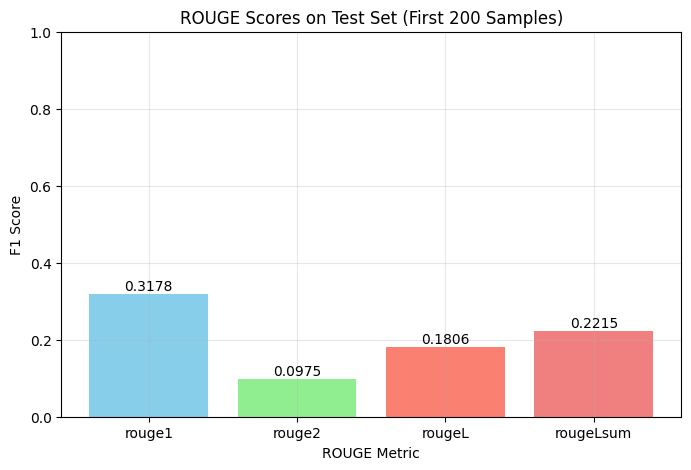

In [37]:
plot_rouge(rouge_results, num_test)

## Fine Tuning

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset
from peft import LoraConfig, get_peft_model
slm_model_name = "Qwen/Qwen2.5-0.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(slm_model_name)
model = AutoModelForCausalLM.from_pretrained(
    slm_model_name,
    device_map="auto",          
    load_in_4bit=True
)

# prep dataset for fine-tuning
def format_example(example):
    prompt = f"""<human>: Résume en quelques phrases en français l'article suivant. Il faut que le résumé soit court et représente les informations les plus importantes.

ARTICLE: {example['text']}

<assistant>: {example['summary']}"""
    return {"text": prompt}

train_dataset = Dataset.from_list([format_example(x) for x in train_data])
val_dataset = Dataset.from_list([format_example(x) for x in val_data])


def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=1024,
        padding="max_length"
    )
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs


tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# LoRA for efficient fine-tuning :)
lora_config = LoraConfig(
    r=16,                # rank
    lora_alpha=32,       #scaling factor
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],#["q_proj", "v_proj"],  # Qwen-specific layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# Training arguments
training_args = TrainingArguments(
    output_dir="./qwen2.5-0.5b-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,          
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,  
    learning_rate=2e-4,
    warmup_steps=100,
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=200,             #checkpoint every 200 steps
    save_total_limit=2,         # keep last 2 checkpoints
    fp16=True,               
    report_to="none"  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer
)

# fine-tune:
trainer.train()

#save
model.save_pretrained("./qwen2.5-0.5b-finetuned-final")
tokenizer.save_pretrained("./qwen2.5-0.5b-finetuned-final")
print("Fine-tuning complete. Model saved to './qwen2.5-0.5b-finetuned-final'.")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<ipython-input-22-701e5b39fe17>:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Step,Training Loss,Validation Loss
50,2.737900,2.635225
100,2.532300,2.502820
150,2.443400,2.480244
200,2.448200,2.458887
250,2.419400,2.444542
300,2.378700,2.438733
350,2.469900,2.429920
400,2.414400,2.423875
450,2.386300,2.420974
500,2.379200,2.417652


Fine-tuning complete. Model saved to './qwen2.5-0.5b-finetuned-final'.


In [ ]:
# to save model to drive from google colab
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/qwen2.5-0.5b-finetuned-final /content/drive/MyDrive/qwen2.5-0.5b-finetuned-final

Mounted at /content/drive


### To plot the loss

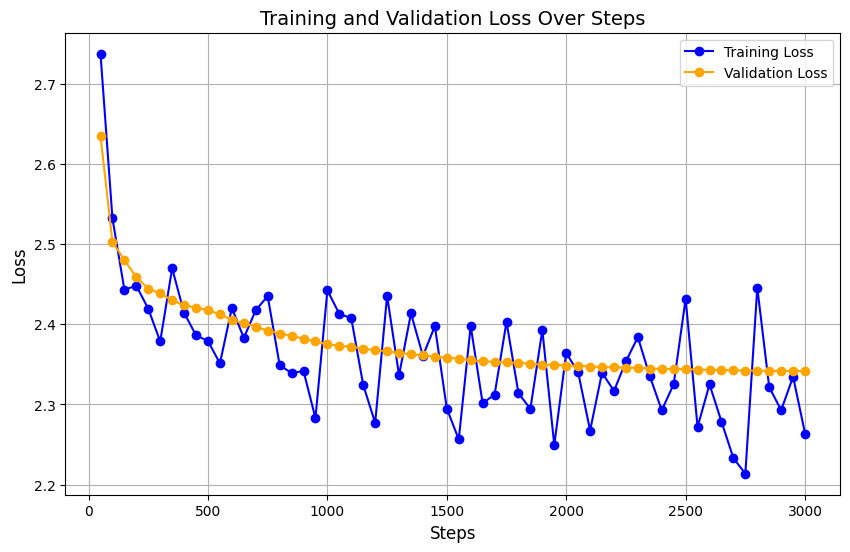

In [ ]:

import matplotlib.pyplot as plt
import csv

steps = []
training_loss = []
validation_loss = []

with open("loss.csv", "r") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for row in reader:
        steps.append(int(row["Step"]))
        training_loss.append(float(row["Training Loss"]))
        validation_loss.append(float(row["Validation Loss"]))

plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label="Training Loss", marker="o", color="blue")
plt.plot(steps, validation_loss, label="Validation Loss", marker="o", color="orange")

plt.title("Training and Validation Loss Over Steps", fontsize=14)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

### Evaluate after fine tuning

In [ ]:
# load model from google drive
from google.colab import drive
drive.mount('/content/drive')
!cp -r '/content/drive/MyDrive/qwen2.5-0.5b-finetuned-final' '/content/'

Mounted at /content/drive


In [ ]:
# eval fine tuned model on test set

SLM = AutoModelForCausalLM.from_pretrained("./qwen2.5-0.5b-finetuned-final", device_map="auto", load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained("./qwen2.5-0.5b-finetuned-final")

num_test=100 # MAX 500 takes too long on whole test data
rouge_results = evaluate_model(SLM, tokenizer, test_data[:num_test])
plot_rouge(rouge_results, num_test)

In [ ]:
###############
###############